# L.A. County places and U.S. Census tracts

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
import re
import unicodedata
from datetime import datetime, date

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Get tracts

In [6]:
url = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/census-tracts-2012.geojson"

In [7]:
src_tracts = gpd.read_file(url)

In [8]:
src_tracts.columns = (
    src_tracts.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("/", "_", regex=False)
)

In [9]:
src_tracts = src_tracts.to_crs("EPSG:3311")

In [10]:
src_tracts["tract_area"] = round(src_tracts["geometry"].area / 2.59e6, 2)

In [11]:
merged = src_tracts.copy()

In [12]:
merged.rename(columns={"name": "geoid"}, inplace=True)

### Age data

In [13]:
src_age = pd.read_csv(
    "input/ACSST5Y2019.S0101_2021-04-12T110603/ACSST5Y2019.S0101_data_with_overlays_2021-04-12T110551.csv",
    dtype={"geoid": str},
    skiprows=range(1, 2),
)

In [14]:
src_age.head()

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,S0101_C01_005E,S0101_C01_005M,S0101_C01_006E,S0101_C01_006M,S0101_C01_007E,S0101_C01_007M,S0101_C01_008E,S0101_C01_008M,S0101_C01_009E,S0101_C01_009M,S0101_C01_010E,S0101_C01_010M,S0101_C01_011E,S0101_C01_011M,S0101_C01_012E,...,S0101_C06_026M,S0101_C06_027E,S0101_C06_027M,S0101_C06_028E,S0101_C06_028M,S0101_C06_029E,S0101_C06_029M,S0101_C06_030E,S0101_C06_030M,S0101_C06_031E,S0101_C06_031M,S0101_C06_032E,S0101_C06_032M,S0101_C06_033E,S0101_C06_033M,S0101_C06_034E,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M
0,1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",4283,443,283,117,259,103,200,105,169,78,254,154,321,124,331,131,234,103,321,107,303,121,277,...,4.6,81.7,4.7,27.2,5.8,25.8,5.7,21.4,5.3,10.2,3.9,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,1400000US06037101122,"Census Tract 1011.22, Los Angeles County, Cali...",3405,334,78,50,105,98,234,150,51,42,250,130,188,112,347,182,122,65,89,49,94,64,474,...,7.1,84.5,7.1,31.6,6.6,27.3,5.8,23.4,5.1,8.3,4.8,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,1400000US06037101210,"Census Tract 1012.10, Los Angeles County, Cali...",6347,484,422,274,477,190,383,185,383,176,466,163,366,143,482,220,663,192,367,181,373,174,560,...,6.4,73.9,6.1,15.1,4.1,14.7,4.0,9.8,3.0,2.1,2.3,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1400000US06037101220,"Census Tract 1012.20, Los Angeles County, Cali...",3702,276,138,87,162,62,309,120,238,75,209,78,201,76,302,109,239,99,274,92,221,78,224,...,4.5,74.5,4.8,21.6,4.7,19.1,4.5,14.7,3.6,8.6,3.6,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1400000US06037101300,"Census Tract 1013, Los Angeles County, California",3884,394,89,62,214,114,93,66,89,48,136,136,300,164,160,96,149,77,214,94,291,102,329,...,3.8,90.5,4.0,41.4,6.1,36.1,5.8,28.3,5.7,16.2,4.8,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [15]:
df_age = src_age[
    [
        "GEO_ID",
        "S0101_C01_001E",
        "S0101_C01_002E",
        "S0101_C01_003E",
        "S0101_C01_004E",
        "S0101_C01_005E",
        "S0101_C01_006E",
        "S0101_C01_007E",
        "S0101_C01_008E",
        "S0101_C01_009E",
        "S0101_C01_010E",
        "S0101_C01_011E",
        "S0101_C01_012E",
        "S0101_C01_013E",
        "S0101_C01_014E",
        "S0101_C01_015E",
        "S0101_C01_016E",
        "S0101_C01_017E",
        "S0101_C01_018E",
        "S0101_C01_019E",
    ]
].rename(
    columns={
        "GEO_ID": "geoid",
        "S0101_C01_001E": "total_population",
        "S0101_C01_002E": "under_5_years",
        "S0101_C01_003E": "5_to_9_years",
        "S0101_C01_004E": "10_to_14_years",
        "S0101_C01_005E": "15_to_19_years",
        "S0101_C01_006E": "20_to_24_years",
        "S0101_C01_007E": "25_to_29_years",
        "S0101_C01_008E": "30_to_34_years",
        "S0101_C01_009E": "35_to_39_years",
        "S0101_C01_010E": "40_to_44_years",
        "S0101_C01_011E": "45_to_49_years",
        "S0101_C01_012E": "50_to_54_years",
        "S0101_C01_013E": "55_to_59_years",
        "S0101_C01_014E": "60_to_64_years",
        "S0101_C01_015E": "65_to_69_years",
        "S0101_C01_016E": "70_to_74_years",
        "S0101_C01_017E": "75_to_79_years",
        "S0101_C01_018E": "80_to_84_years",
        "S0101_C01_019E": "85_years_and_over",
    }
)

In [16]:
df_age["geoid"] = df_age["geoid"].str.replace("1400000US", "", regex=False)

---

### What's the standard population in L.A. County?

In [17]:
# la_county_age = df_age

In [18]:
df_age

,geoid,total_population,under_5_years,5_to_9_years,10_to_14_years,15_to_19_years,20_to_24_years,25_to_29_years,30_to_34_years,35_to_39_years,40_to_44_years,45_to_49_years,50_to_54_years,55_to_59_years,60_to_64_years,65_to_69_years,70_to_74_years,75_to_79_years,80_to_84_years,85_years_and_over
0,06037101110,4283,283,259,200,169,254,321,331,234,321,303,277,384,220,358,72,123,96,78
1,06037101122,3405,78,105,234,51,250,188,347,122,89,94,474,361,332,230,187,123,96,44
2,06037101210,6347,422,477,383,383,466,366,482,663,367,373,560,375,406,244,148,131,50,51
3,06037101220,3702,138,162,309,238,209,201,302,239,274,221,224,345,244,175,131,129,98,63
4,06037101300,3884,89,214,93,89,136,300,160,149,214,291,329,317,563,242,200,215,57,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,06037980031,1175,20,0,5,0,62,41,185,150,206,130,140,72,50,51,50,13,0,0
2342,06037980033,16,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0
2343,06037990100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2344,06037990200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# la_county_age.drop(["geoid"], axis=1, inplace=True)

In [20]:
# la_county_age.head()

In [21]:
# lacounty_age_cols = [
#     "under_5_years",
#     "5_to_9_years",
#     "10_to_14_years",
#     "15_to_19_years",
#     "20_to_24_years",
#     "25_to_29_years",
#     "30_to_34_years",
#     "35_to_39_years",
#     "40_to_44_years",
#     "45_to_49_years",
#     "50_to_54_years",
#     "55_to_59_years",
#     "60_to_64_years",
#     "65_to_69_years",
#     "70_to_74_years",
#     "75_to_79_years",
#     "80_to_84_years",
#     "85_years_and_over",
# ]

In [22]:
# for c in lacounty_age_cols:
#     la_county_age[f"est_{c}_pct"] = round(
#         (la_county_age[f"{c}"] / la_county_age.total_population) * 100, 2
#     )

In [23]:
# la_county_age.to_csv("output/la_county_standard_population.csv", index=False)

---

### Merge age dataframe with tracts geography for L.A. County

In [24]:
la_tracts = pd.merge(merged, df_age, on="geoid")

<AxesSubplot:>

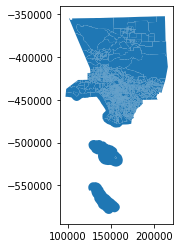

In [25]:
la_tracts.plot()

In [26]:
la_tracts.head()

,kind,external_id,geoid,slug,set,metadata,resource_uri,geometry,tract_area,total_population,under_5_years,5_to_9_years,10_to_14_years,15_to_19_years,20_to_24_years,25_to_29_years,30_to_34_years,35_to_39_years,40_to_44_years,45_to_49_years,50_to_54_years,55_to_59_years,60_to_64_years,65_to_69_years,70_to_74_years,75_to_79_years,80_to_84_years,85_years_and_over
0,Census Tract (2012),06037101110,06037101110,06037101110-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2594737', 'NAME': '1011.10',...",/1.0/boundary/06037101110-census-tract-2012/,"MULTIPOLYGON (((156321.347 -416068.552, 156459...",0.44,4283,283,259,200,169,254,321,331,234,321,303,277,384,220,358,72,123,96,78
1,Census Tract (2012),06037101122,06037101122,06037101122-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2677213', 'NAME': '1011.22',...",/1.0/boundary/06037101122-census-tract-2012/,"MULTIPOLYGON (((156195.858 -414424.087, 156209...",1.02,3405,78,105,234,51,250,188,347,122,89,94,474,361,332,230,187,123,96,44
2,Census Tract (2012),06037101210,06037101210,06037101210-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2529724', 'NAME': '1012.10',...",/1.0/boundary/06037101210-census-tract-2012/,"MULTIPOLYGON (((156588.229 -416365.498, 157833...",0.25,6347,422,477,383,383,466,366,482,663,367,373,560,375,406,244,148,131,50,51
3,Census Tract (2012),06037101220,06037101220,06037101220-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2516085', 'NAME': '1012.20',...",/1.0/boundary/06037101220-census-tract-2012/,"MULTIPOLYGON (((157847.743 -417121.716, 157833...",0.27,3702,138,162,309,238,209,201,302,239,274,221,224,345,244,175,131,129,98,63
4,Census Tract (2012),06037101300,06037101300,06037101300-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2487732', 'NAME': '1013', 'I...",/1.0/boundary/06037101300-census-tract-2012/,"MULTIPOLYGON (((159119.507 -418922.080, 159167...",1.00,3884,89,214,93,89,136,300,160,149,214,291,329,317,563,242,200,215,57,226


---

### Get L.A. County places

In [27]:
places_geo = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [28]:
places_geo = places_geo.to_crs("EPSG:3311")

In [29]:
places_geo.columns = places_geo.columns.str.lower()

In [30]:
len(places_geo)

348

In [31]:
places_geo["place_area"] = round(places_geo["geometry"].area / 2.59e6, 2)

In [32]:
places_geo.head()

,name,geometry,place_area
0,Agoura Hills,"MULTIPOLYGON (((117201.354 -426752.672, 116472...",7.82
1,Bellflower,"MULTIPOLYGON (((174818.350 -454427.122, 174810...",6.18
2,Beverly Hills,"MULTIPOLYGON (((148374.547 -432436.704, 148309...",5.71
3,Burbank,"MULTIPOLYGON (((156006.516 -426897.025, 156303...",17.34
4,Calabasas,"MULTIPOLYGON (((120408.368 -426638.916, 120344...",13.76


<AxesSubplot:>

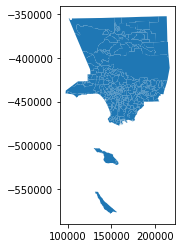

In [33]:
places_geo.plot()

---

### What pct of each tract is in each place? 

In [34]:
merged = gpd.sjoin(la_tracts, places_geo)

In [35]:
merged.iloc[1]

kind                                               Census Tract (2012)
external_id                                                06037101122
geoid                                                      06037101122
slug                                     06037101122-census-tract-2012
set                              /1.0/boundary-set/census-tracts-2012/
metadata             {'INTPTLAT': '+34.2677213', 'NAME': '1011.22',...
resource_uri              /1.0/boundary/06037101122-census-tract-2012/
geometry             (POLYGON ((156195.8580611995 -414424.087415218...
tract_area                                                        1.02
total_population                                                  3405
under_5_years                                                       78
5_to_9_years                                                       105
10_to_14_years                                                     234
15_to_19_years                                                      51
20_to_

In [36]:
merged[merged["name"] == "Playa Del Rey"]

,kind,external_id,geoid,slug,set,metadata,resource_uri,geometry,tract_area,total_population,under_5_years,5_to_9_years,10_to_14_years,15_to_19_years,20_to_24_years,25_to_29_years,30_to_34_years,35_to_39_years,40_to_44_years,45_to_49_years,50_to_54_years,55_to_59_years,60_to_64_years,65_to_69_years,70_to_74_years,75_to_79_years,80_to_84_years,85_years_and_over,index_right,name,place_area
914,Census Tract (2012),06037274202,06037274202,06037274202-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9719816', 'NAME': '2742.02',...",/1.0/boundary/06037274202-census-tract-2012/,"MULTIPOLYGON (((141213.608 -447633.965, 141525...",0.86,4284,189,110,70,80,49,344,375,470,263,186,417,292,461,281,204,271,76,146,43,Playa Del Rey,0.67
928,Census Tract (2012),06037276601,06037276601,06037276601-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9637725', 'NAME': '2766.01',...",/1.0/boundary/06037276601-census-tract-2012/,"MULTIPOLYGON (((143689.510 -449343.457, 143758...",0.87,4115,237,134,188,149,262,310,375,267,303,325,251,281,273,309,148,133,66,104,43,Playa Del Rey,0.67
929,Census Tract (2012),06037276603,06037276603,06037276603-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9558339', 'NAME': '2766.03',...",/1.0/boundary/06037276603-census-tract-2012/,"MULTIPOLYGON (((143965.339 -449814.829, 144028...",0.18,5489,145,93,316,136,198,801,838,636,426,297,428,161,247,288,197,192,13,77,43,Playa Del Rey,0.67
936,Census Tract (2012),06037278102,06037278102,06037278102-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9583368', 'NAME': '2781.02',...",/1.0/boundary/06037278102-census-tract-2012/,"MULTIPOLYGON (((141964.138 -449587.677, 142318...",1.27,3088,128,24,94,54,62,276,423,314,193,293,210,174,261,315,150,94,8,15,43,Playa Del Rey,0.67
2146,Census Tract (2012),06037702901,06037702901,06037702901-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9815095', 'NAME': '7029.01',...",/1.0/boundary/06037702901-census-tract-2012/,"MULTIPOLYGON (((141980.056 -447119.044, 142749...",1.45,9852,520,99,0,353,747,1265,971,1574,478,607,784,827,605,383,242,145,110,142,43,Playa Del Rey,0.67
2339,Census Tract (2012),06037980028,06037980028,06037980028-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+33.9421080', 'NAME': '9800.28',...",/1.0/boundary/06037980028-census-tract-2012/,"MULTIPOLYGON (((143066.949 -451305.479, 143617...",7.59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,Playa Del Rey,0.67


---

### Get the share of the tract that's within its parent neighborhood

In [37]:
def get_tract_share(row):
    tract_shape = merged[merged.geoid == row["geoid"]].iloc[0].geometry
    hood_shape = places_geo[places_geo.name == row["name"]].iloc[0].geometry
    intersection = tract_shape.intersection(hood_shape)
    tract_area = tract_shape.area
    intersection_area = intersection.area
    return intersection_area / tract_area

In [38]:
merged["tract_percent"] = round(merged.apply(get_tract_share, axis=1), 5)

In [39]:
merged = merged.sort_values("tract_percent", ascending=False)

In [40]:
merged["total_population"] = merged["total_population"] * merged["tract_percent"]
merged["under_5_years"] = merged["under_5_years"] * merged["tract_percent"]
merged["5_to_9_years"] = merged["5_to_9_years"] * merged["tract_percent"]
merged["10_to_14_years"] = merged["10_to_14_years"] * merged["tract_percent"]
merged["15_to_19_years"] = merged["15_to_19_years"] * merged["tract_percent"]
merged["20_to_24_years"] = merged["20_to_24_years"] * merged["tract_percent"]
merged["25_to_29_years"] = merged["25_to_29_years"] * merged["tract_percent"]
merged["30_to_34_years"] = merged["30_to_34_years"] * merged["tract_percent"]
merged["35_to_39_years"] = merged["35_to_39_years"] * merged["tract_percent"]
merged["40_to_44_years"] = merged["40_to_44_years"] * merged["tract_percent"]
merged["45_to_49_years"] = merged["45_to_49_years"] * merged["tract_percent"]
merged["50_to_54_years"] = merged["50_to_54_years"] * merged["tract_percent"]
merged["55_to_59_years"] = merged["55_to_59_years"] * merged["tract_percent"]
merged["60_to_64_years"] = merged["60_to_64_years"] * merged["tract_percent"]
merged["65_to_69_years"] = merged["65_to_69_years"] * merged["tract_percent"]
merged["70_to_74_years"] = merged["70_to_74_years"] * merged["tract_percent"]
merged["75_to_79_years"] = merged["75_to_79_years"] * merged["tract_percent"]
merged["80_to_84_years"] = merged["80_to_84_years"] * merged["tract_percent"]
merged["85_years_and_over"] = merged["85_years_and_over"] * merged["tract_percent"]

---

### Aggregate up our U.S. Census variables

In [41]:
places_totals = (
    merged.groupby(["name"])
    .agg(
        {
            "total_population": sum,
            "under_5_years": sum,
            "5_to_9_years": sum,
            "10_to_14_years": sum,
            "15_to_19_years": sum,
            "20_to_24_years": sum,
            "25_to_29_years": sum,
            "30_to_34_years": sum,
            "35_to_39_years": sum,
            "40_to_44_years": sum,
            "45_to_49_years": sum,
            "50_to_54_years": sum,
            "55_to_59_years": sum,
            "60_to_64_years": sum,
            "65_to_69_years": sum,
            "70_to_74_years": sum,
            "75_to_79_years": sum,
            "80_to_84_years": sum,
            "85_years_and_over": sum,
        }
    )
    .reset_index()
    .sort_values("total_population", ascending=False)
).round()

In [42]:
place_age_cols = [
    "under_5_years",
    "5_to_9_years",
    "10_to_14_years",
    "15_to_19_years",
    "20_to_24_years",
    "25_to_29_years",
    "30_to_34_years",
    "35_to_39_years",
    "40_to_44_years",
    "45_to_49_years",
    "50_to_54_years",
    "55_to_59_years",
    "60_to_64_years",
    "65_to_69_years",
    "70_to_74_years",
    "75_to_79_years",
    "80_to_84_years",
]

In [43]:
for c in place_age_cols:
    places_totals[f"est_{c}_pct"] = round(
        (places_totals[f"{c}"] / places_totals["total_population"]) * 100, 2
    )

In [44]:
places_totals.head()

,name,total_population,under_5_years,5_to_9_years,10_to_14_years,15_to_19_years,20_to_24_years,25_to_29_years,30_to_34_years,35_to_39_years,40_to_44_years,45_to_49_years,50_to_54_years,55_to_59_years,60_to_64_years,65_to_69_years,70_to_74_years,75_to_79_years,80_to_84_years,85_years_and_over,est_under_5_years_pct,est_5_to_9_years_pct,est_10_to_14_years_pct,est_15_to_19_years_pct,est_20_to_24_years_pct,est_25_to_29_years_pct,est_30_to_34_years_pct,est_35_to_39_years_pct,est_40_to_44_years_pct,est_45_to_49_years_pct,est_50_to_54_years_pct,est_55_to_59_years_pct,est_60_to_64_years_pct,est_65_to_69_years_pct,est_70_to_74_years_pct,est_75_to_79_years_pct,est_80_to_84_years_pct
154,Long Beach,458969.0,30659.0,28822.0,29063.0,29310.0,35361.0,40586.0,37916.0,31829.0,30443.0,30446.0,30267.0,26953.0,25428.0,19115.0,12741.0,8027.0,5058.0,6945.0,6.68,6.28,6.33,6.39,7.70,8.84,8.26,6.93,6.63,6.63,6.59,5.87,5.54,4.16,2.78,1.75,1.10
96,Glendale,200287.0,9819.0,9696.0,10076.0,9629.0,10644.0,15953.0,15337.0,14092.0,12651.0,14277.0,14867.0,14452.0,13640.0,10175.0,8039.0,6224.0,5444.0,5274.0,4.90,4.84,5.03,4.81,5.31,7.97,7.66,7.04,6.32,7.13,7.42,7.22,6.81,5.08,4.01,3.11,2.72
231,Santa Clarita,199950.0,13731.0,14067.0,14809.0,14268.0,12625.0,13097.0,12172.0,13724.0,13004.0,15355.0,15079.0,13402.0,11258.0,8197.0,5255.0,4368.0,2689.0,2851.0,6.87,7.04,7.41,7.14,6.31,6.55,6.09,6.86,6.50,7.68,7.54,6.70,5.63,4.10,2.63,2.18,1.34
186,Palmdale,182714.0,14280.0,14347.0,16433.0,15521.0,14082.0,12814.0,10896.0,10306.0,11769.0,12326.0,12062.0,11679.0,9067.0,6502.0,3933.0,3076.0,1972.0,1650.0,7.82,7.85,8.99,8.49,7.71,7.01,5.96,5.64,6.44,6.75,6.60,6.39,4.96,3.56,2.15,1.68,1.08
140,Lancaster,154447.0,11771.0,12036.0,12317.0,11639.0,9835.0,12985.0,10366.0,10089.0,9742.0,8920.0,10198.0,9807.0,8568.0,5799.0,4036.0,2770.0,1987.0,1582.0,7.62,7.79,7.97,7.54,6.37,8.41,6.71,6.53,6.31,5.78,6.60,6.35,5.55,3.75,2.61,1.79,1.29


---

### Adjusted rates for age

In [45]:
places_totals_slim = places_totals[
    [
        "under_5_years",
        "5_to_9_years",
        "10_to_14_years",
        "15_to_19_years",
        "20_to_24_years",
        "25_to_29_years",
        "30_to_34_years",
        "35_to_39_years",
        "40_to_44_years",
        "45_to_49_years",
        "50_to_54_years",
        "55_to_59_years",
        "60_to_64_years",
        "65_to_69_years",
        "70_to_74_years",
        "75_to_79_years",
        "80_to_84_years",
    ]
].copy()

In [46]:
la_county_pcts = la_county_age[
    [
        "est_under_5_years_pct",
        "est_5_to_9_years_pct",
        "est_10_to_14_years_pct",
        "est_15_to_19_years_pct",
        "est_20_to_24_years_pct",
        "est_25_to_29_years_pct",
        "est_30_to_34_years_pct",
        "est_35_to_39_years_pct",
        "est_40_to_44_years_pct",
        "est_45_to_49_years_pct",
        "est_50_to_54_years_pct",
        "est_55_to_59_years_pct",
        "est_60_to_64_years_pct",
        "est_65_to_69_years_pct",
        "est_70_to_74_years_pct",
        "est_75_to_79_years_pct",
        "est_80_to_84_years_pct",
    ]
].copy()

NameError: name 'la_county_age' is not defined

In [ ]:
la_county_pcts["name"] = "Los Angeles County"

In [ ]:
age_adjusted = pd.concat([la_county_pcts, place_pcts])

In [ ]:
age_adjusted_df = pd.DataFrame(age_adjusted.T)

In [ ]:
new_header = age_adjusted_df.iloc[17]
df = age_adjusted_df[1:]
df.columns = new_header

In [ ]:
adjusted_cols = [col for col in df.columns if "County" not in col]

---

In [ ]:
places_geo_merge = places_geo.merge(places_totals, on="name")

In [ ]:
places_geo_merge.to_file("output/places_geo_merge_age.geojson", driver="GeoJSON")

In [ ]:
places_totals.to_csv("output/places_totals_age.csv", index=False)